# **Modeling the Relationship Between Temperature and Vapor Pressure**

## **Project Overview**

In this project, we explore the `pressure` dataset from R’s built-in datasets. The goal is to:

1. Fit a simple linear regression model of pressure (response) on temperature (predictor).  
2. Examine whether transformations of the response variable can improve model fit.  
3. Investigate and account for potential autocorrelation in residuals, using generalized least squares with an AR(1) structure.

By the end, we will demonstrate how to move from an initially poor-fitting model to a transformation-based model that captures nearly all of the variance—and how to balance interpretability versus predictive performance.

---

## **1. Load Packages and Data**

In [1]:
# Load required libraries
library(MASS)
library(nlme)
library(performance)

# Inspect the first few rows of the data
head(pressure)

,temperature,pressure
,<dbl>,<dbl>
1,0,0.0002
2,20,0.0012
3,40,0.0060
4,60,0.0300
5,80,0.0900
6,100,0.2700


### **Data Description**

- **temperature**: The temperature (in degrees Celsius).  
- **pressure**: The measured vapor pressure of mercury (in millimeters).  

We suspect from the outset that **pressure** may increase in a nonlinear (particularly exponential) fashion with rising **temperature**.

---

## **2. Initial Model: Untransformed Linear Regression**

Here, we fit a simple linear regression model `pressure ~ temperature`.


Call:
lm(formula = pressure ~ temperature, data = pressure)

Residuals:
    Min      1Q  Median      3Q     Max 
-158.08 -117.06  -32.84   72.30  409.43 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -147.8989    66.5529  -2.222 0.040124 *  
temperature    1.5124     0.3158   4.788 0.000171 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 150.8 on 17 degrees of freedom
Multiple R-squared:  0.5742,	Adjusted R-squared:  0.5492 
F-statistic: 22.93 on 1 and 17 DF,  p-value: 0.000171


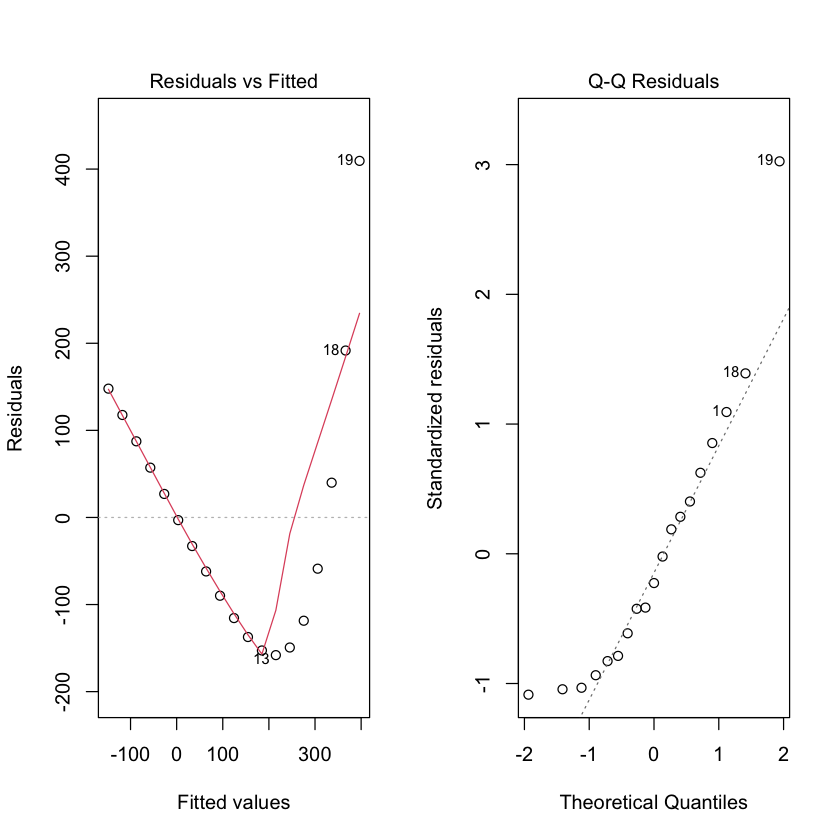

In [2]:
# Fit a linear model with no transformation
lmod_orig <- lm(pressure ~ temperature, data = pressure)

# Brief summary
summary(lmod_orig)

# Diagnostic plots
par(mfrow = c(1, 2))
plot(lmod_orig, which = 1)  # Residuals vs Fitted
plot(lmod_orig, which = 2)  # Q-Q plot

### **Observations**

- The residuals show a distinct pattern, indicating potential nonlinearity and/or autocorrelation.  
- There is also a suggestion of non-normal errors.  
- The R² value is relatively low (~0.57), indicating the linear model does not capture the relationship particularly well.

---

## **3. Exploring Transformations**

A quick plot of pressure vs. temperature suggests an exponential growth pattern in pressure. This hints that a log transformation could linearize the relationship. We also use Box-Cox to confirm the best transformation.

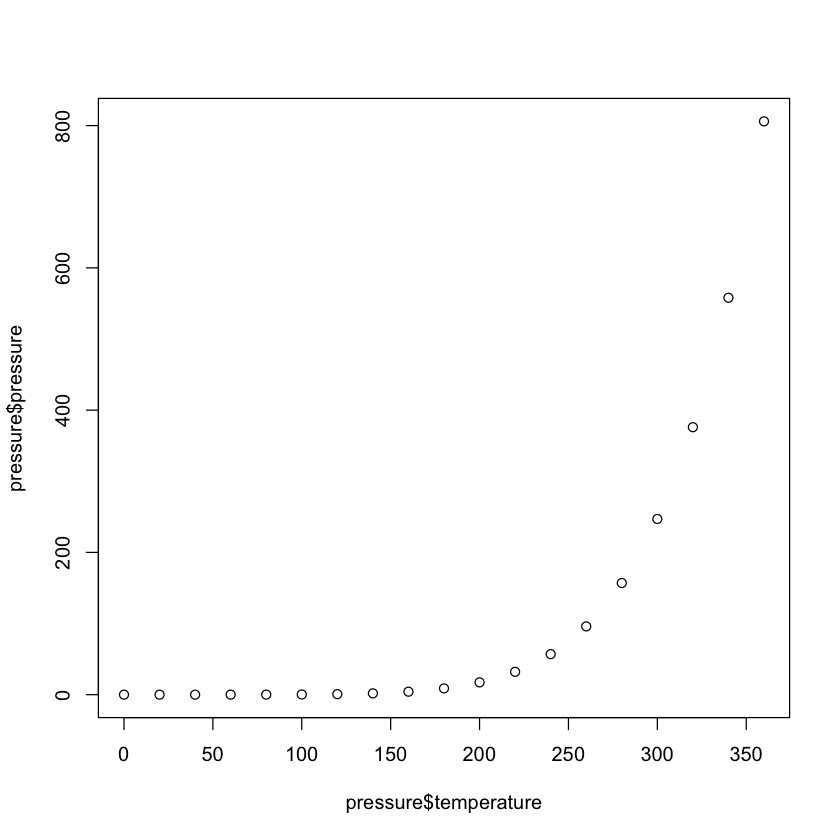

[1] "Optimal lambda: 0.12020202020202"


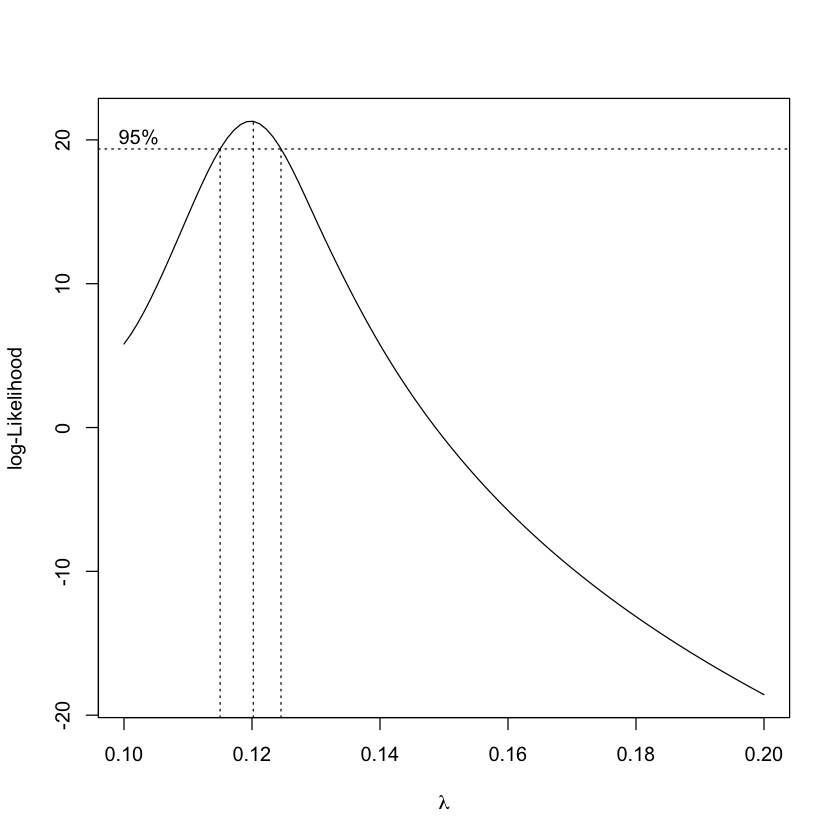

In [3]:
# Plot pressure vs temperature
plot(pressure$temperature, pressure$pressure)

# Box-Cox analysis
bc_result <- boxcox(lmod_orig, lambda = seq(0.1, 0.2, 0.01))

# Identify the optimal lambda
optimal_lambda <- bc_result$x[which.max(bc_result$y)]
print(paste("Optimal lambda:", optimal_lambda))

- The Box-Cox procedure suggests an optimal lambda around **0.12**.  
- A λ of 0.12 is quite close to **0**, meaning a **log** transform is likely to be effective and more interpretable.

### **3.1 Creating Transformed Variables**

We try both the exact Box-Cox transform and a simpler log transform.  

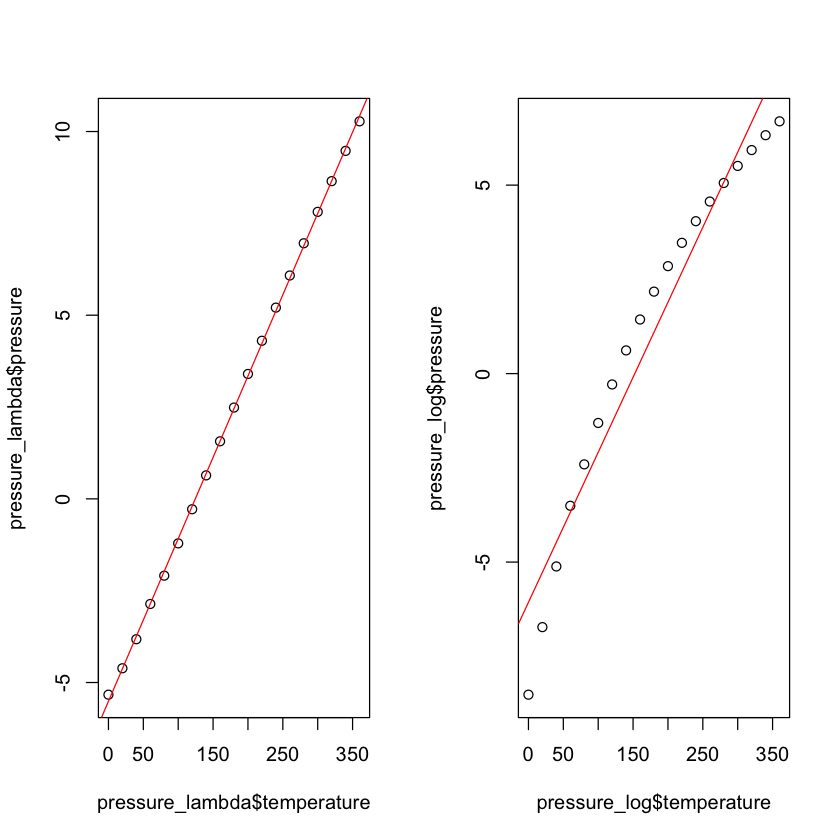

In [4]:
# Create the y-transformation with lambda ~ 0.12
g_y <- (pressure$pressure^optimal_lambda - 1) / optimal_lambda
pressure_lambda <- data.frame(
  temperature = pressure$temperature, 
  pressure = g_y
)

# Create the log-transformed pressure
pressure_log <- pressure
pressure_log$pressure <- log(pressure$pressure)

# Visually compare transformations
par(mfrow = c(1, 2))
plot(pressure_lambda$temperature, pressure_lambda$pressure)
abline(lm(pressure_lambda$pressure ~ pressure_lambda$temperature), col = "red")

plot(pressure_log$temperature, pressure_log$pressure)
abline(lm(pressure_log$pressure ~ pressure_log$temperature), col = "red")

From these plots, the Box-Cox transform at λ = 0.12 appears almost perfectly linear, but the log transformation also does a good job.

---

## **4. Comparing Model Performance**

We compare three models:

1. **Original model** with raw `pressure`.  
2. **Log model** with `log(pressure)`.  
3. **Lambda model** with the Box-Cox transform (λ ≈ 0.12).

In [5]:
# Fit models
lmod_lambda <- lm(pressure ~ temperature, data = pressure_lambda)
lmod_log <- lm(pressure ~ temperature, data = pressure_log)

# Compare performance
performance_df <- compare_performance(lmod_orig, lmod_log, lmod_lambda)
performance_df <- as.data.frame(performance_df)
performance_df <- performance_df[, c("Name","R2", "RMSE", "Sigma")]
performance_df

When comparing models, please note that probably not all models were fit
  from same data.



Name,R2,RMSE,Sigma
<chr>,<dbl>,<dbl>,<dbl>
lmod_orig,0.5742492,142.65615118,150.81441106
lmod_log,0.9464264,1.03709125,1.09640072
lmod_lambda,0.9996903,0.08533722,0.09021751


### **Key Takeaways**

- The **original model** had an R² ~ **0.57**.  
- The **log model** soared to ~ **0.95** R².  
- The **lambda model** approached **1.00** R², which implies a near-perfect fit.  

If your goal is **pure predictive accuracy**, the λ-transformed model outperforms the rest. However, if you prize **interpretability**, the **log model** is still a solid choice—it’s easily invertible via the exponential to get predictions back on the original scale.

---

## **5. Checking for Autocorrelation**

The residuals still showed a suspicious pattern. Let’s see if they’re autocorrelated (i.e., whether residuals at consecutive observations are correlated).

In [6]:
lambda_residuals <- residuals(lmod_lambda)
lagged_residuals_lambda <- lambda_residuals[-1]
current_residuals_lambda <- lambda_residuals[-length(lambda_residuals)]
cor(lagged_residuals_lambda, current_residuals_lambda)

log_residuals <- residuals(lmod_log)
lagged_residuals_log <- log_residuals[-1]
current_residuals_log <- log_residuals[-length(log_residuals)]
cor(lagged_residuals_log, current_residuals_log)

[1] 0.6786949

[1] 0.9002051

These correlations are quite high, confirming significant positive autocorrelation. This suggests the presence of a time series (or temperature-ordered) effect in the data. Simply put, the residual at temperature `T` is correlated with the residual at `T+1`.

---

## **6. Generalized Least Squares with AR(1) Error Structure**

To address autocorrelated errors, we use **GLS** (generalized least squares) and specify a corAR1 structure.

In [7]:
# GLS with AR(1) for the log model
lmod_log_ar1 <- gls(pressure ~ temperature, 
                    data = pressure_log, 
                    correlation = corAR1(form = ~ 1))

# GLS with AR(1) for the lambda model
lmod_lambda_ar1 <- gls(pressure ~ temperature, 
                       data = pressure_lambda, 
                       correlation = corAR1(form = ~ 1))

# Compare performance
performance_df <- compare_performance(lmod_log, lmod_log_ar1, 
                                      lmod_lambda, lmod_lambda_ar1)
performance_df <- as.data.frame(performance_df)
performance_df <- performance_df[, c("Name","R2", "RMSE", "Sigma")]
performance_df

When comparing models, please note that probably not all models were fit
  from same data.



Name,R2,RMSE,Sigma
<chr>,<dbl>,<dbl>,<dbl>
lmod_log,0.9464264,1.03709125,1.09640072
lmod_log_ar1,0.7422043,2.27498990,187.51636936
lmod_lambda,0.9996903,0.08533722,0.09021751
lmod_lambda_ar1,0.9992606,0.13185512,13.21039515


### **What We Observe**

- For the **log model** with AR(1), the residual standard error becomes quite large, suggesting the model isn’t very stable in this specification.  
- For the **lambda model** with AR(1), the fit remains excellent (RSE is still small, and R² remains very high). The AR(1) correction picks up the strong correlation in the residuals.  

---

## **7. Final Model Assessment**

1. **Lambda Model** (`pressure^0.12`)  
   - **Pros**: Near-perfect R², minimal residual patterns, fairly robust even after correcting for AR(1).  
   - **Cons**: Interpreting the coefficients is more difficult than a simple log transform.  

2. **Log Model** (`log(pressure)`)  
   - **Pros**: Highly interpretable (multiplicative changes in pressure per degree of temperature).  
   - **Cons**: Not as close to perfect fit as the lambda model; the AR(1) adjustment reveals that the residual standard error can spike under certain assumptions.

If pure predictive accuracy is the top priority, **lmod_lambda** with (or without) the AR(1) structure is best. For a more standard exponential interpretation, **lmod_log** is still a valid approach.

---

## **Conclusion**

- Transformations can drastically improve linear regression fits when the underlying relationship is nonlinear, especially exponential in nature.  
- Box-Cox can guide you to an optimal transformation; however, **log** is often a practical choice due to its interpretability.  
- When data points have sequential dependence (e.g., temperature measurements at ordered intervals), accounting for **autocorrelation** with GLS can further refine model estimates.  
- Ultimately, model selection depends on the balance between **accuracy** (the lambda transform) and **interpretability** (the log transform).

**Thank you for reading** — this walkthrough should help illustrate the process of diagnosing model issues, applying appropriate transformations, and dealing with correlated errors in R. Be sure to check out the code in full, run it yourself, and experiment with additional transformations or correlation structures.

---